In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [45]:
X_train = load('X_train_record.joblib')
X_test = load('X_test_record.joblib')
y_test = load('y_test_record.joblib')

In [46]:
input_dim = 87 # Numero di features per ciascun record
input_length = 600  # Lunghezza fissa delle sequenze

input_layer = tf.keras.Input(shape=(input_length, input_dim))

# Codificatore LSTM
encoder = tf.keras.layers.LSTM(int(input_length/2))(input_layer)

# Vettore di ripetizione
repeat_vector = tf.keras.layers.RepeatVector(input_length)(encoder)

# Decodificatore LSTM
decoder = tf.keras.layers.LSTM(input_dim, return_sequences=True)(repeat_vector)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

optimizer = tf.keras.optimizers.Adam()

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Stampa dell'architettura del modello
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 600, 87)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 300)            │       465,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 600, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 600, 87)        │       135,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,624 (2.29 MB)

 Trainable params: 600,624 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
autoencoder.fit(X_train, X_train, epochs=30, batch_size=256, shuffle=True, verbose=0)

In [7]:
autoencoder.save("autoencoder.keras")

In [48]:
reconstructions = autoencoder.predict(X_test)

loss = []
for i in range(len(X_test)): 
    loss_list=[]
    for j in range(len(X_test[i])):
        loss_value = np.mean(np.abs(reconstructions[i][j] - X_test[i][j]))
        loss_list.append(loss_value)
    loss.append(loss_list)

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step


In [49]:
def curva_precision_recall(y_test, loss):
    precision, recall, thresholds_pr = precision_recall_curve(y_test, loss)
    auc_pr = auc(recall, precision)

    # Trova il threshold ottimale che massimizza l'F1-score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_pr = thresholds_pr[np.argmax(f1_scores)]

    print("AUC-PR:", auc_pr)
    print("Best Threshold (Precision-Recall):", best_threshold_pr)

    # Grafico della curva Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve (AUC-PR = %0.2f)' % auc_pr, color='b')
    plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', marker='o', label='Best F1-Score')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    
    return best_threshold_pr

In [50]:
# Calcola la curva ROC
def curva_roc(y_test,loss):
    fpr, tpr, thresholds_roc = roc_curve(y_test, loss)

    # Calcola l'AUC-ROC
    roc_auc = auc(fpr, tpr)

    # Trova il miglior threshold utilizzando l'AUC-ROC
    optimal_threshold_index = np.argmax(tpr - fpr) #tpr-fpr è l'indice di Youden
    best_threshold_roc = thresholds_roc[optimal_threshold_index]

    print("AUC-ROC:", roc_auc)
    print("Best Threshold (ROC):", best_threshold_roc)

    # Grafico della curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC-ROC = %0.2f)' % roc_auc, color='b')
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return best_threshold_roc

In [51]:
def detect_anomaly(new_data, autoencoder, threshold):
    reconstructions = autoencoder.predict(new_data)
    anomalies=[]
    for i in range(len(X_test)):
        anomalie=[]
        for j in range(len(X_test[i])):
            loss = np.mean(np.abs(reconstructions[i][j] - X_test[i][j]))
            anomalie.append(loss >= threshold)
        anomalies.append(anomalie)
    return anomalies

In [52]:
all_losses = np.concatenate(loss)
all_labels = np.concatenate(y_test)

threshold_precision_recall=curva_precision_recall(all_labels,all_losses)
threshold_auc_roc=curva_roc(all_labels,all_losses)

AUC-PR: 0.2630030252345186
Best Threshold (Precision-Recall): 0.07665403


C:\Users\fraia\AppData\Local\Temp\ipykernel_16944\200469842.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [53]:
print("Threshold PR:", threshold_precision_recall)
print("Threshold ROC:", threshold_auc_roc)

Threshold PR: 0.07665403
Threshold ROC: 0.07236096


In [57]:
predicted_labels_pr = detect_anomaly(X_test, autoencoder, threshold_precision_recall)
predicted_labels_roc=detect_anomaly(X_test, autoencoder, threshold_auc_roc)

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step



Accuracy Totale: 0.6130373230373231


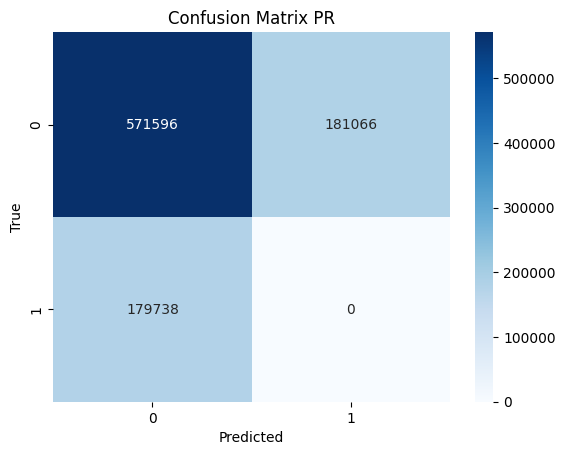

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76    752662
         1.0       0.00      0.00      0.00    179738

    accuracy                           0.61    932400
   macro avg       0.38      0.38      0.38    932400
weighted avg       0.61      0.61      0.61    932400


Accuracy con pr: 0.6130373230373231


In [55]:
all_true_labels = np.concatenate(y_test)
all_predicted_labels = np.concatenate(predicted_labels_pr)

cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Visualizzare la matrice di confusione
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix PR")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(all_true_labels, all_predicted_labels))
print("\nAccuracy con pr:", accuracy_score(all_true_labels, all_predicted_labels))

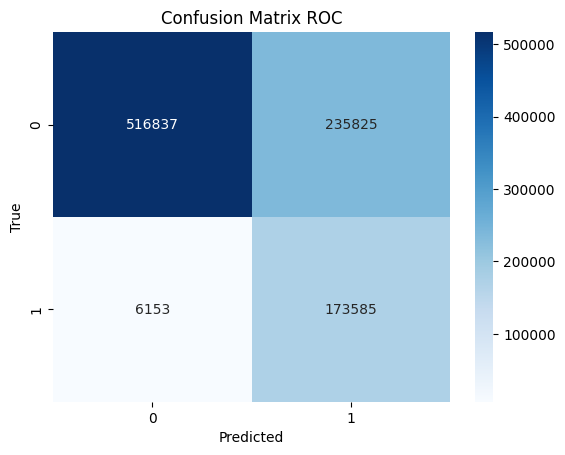

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81    752662
         1.0       0.42      0.97      0.59    179738

    accuracy                           0.74    932400
   macro avg       0.71      0.83      0.70    932400
weighted avg       0.88      0.74      0.77    932400


Accuracy con ROC: 0.7404783354783355


In [58]:
all_true_labels = np.concatenate(y_test) 
all_predicted_labels = np.concatenate(predicted_labels_roc)

cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Visualizzare la matrice di confusione
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix ROC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calcolo della precisione testuale con pr
print(classification_report(all_true_labels, all_predicted_labels))
print("\nAccuracy con ROC:", accuracy_score(all_true_labels, all_predicted_labels))